# Custom Object Detector

Reference: [Training an object detector from scratch in PyTorch](https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/)

In [1]:
import torch
import torch.nn as nn
import torchvision 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

### Dataset

In [3]:
classes = ['Chihuahua', 
           'Golden_retriever', 
           'Welsh_springer_spaniel', 
           'German_shepherd', 
           'Doberman', 
           'Boxer', 
           'Siberian_husky', 
           'Pug', 
           'Pomeranian', 
           'Cardigan']

In [4]:
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = "dataset/standford_dogs_mini_10/yolo"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
IMAGES_FILE_PATHs = os.path.sep.join([BASE_PATH, "image_paths.txt"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output model, label encoder, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.pth"])
LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

### Hyperparameters

In [5]:
# determine the current device and based on that set the pin memory
# flag
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False
# specify ImageNet mean and sta                          Pndard deviation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 64
# specify the loss weights
LABELS = 1.0
BBOX = 1.0

In [6]:
# import the necessary packages
from torch.utils.data import Dataset

class CustomTensorDataset(Dataset):
    def __init__(self,tensors, transforms=None):
        self.tensors = tensors
        self.transforms = transforms

    def __len__(self):
        # return the size of the dataset
        return self.tensors[0].size(0)
    
    def __getitem__(self, index):
        # grab the image, label, and its bounding box coordinates
        image = self.tensors[0][index]
        label = self.tensors[1][index]
        bbox = self.tensors[2][index]
        # transpose the image such that its channel dimension becomes
        # the leading one
        image = image.permute(2, 0, 1)
        # check to see if we have any image transformations to apply
        # and if so, apply them
        if self.transforms:
            image = self.transforms(image)
        # return a tuple of the images, labels, and bounding
        # box coordinates
        return (image, label, bbox)

### Custom model

In [7]:
class ObjectDetector(nn.Module):
    def __init__(self, basemodel, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = basemodel

        self.classifier = nn.Sequential(
            nn.Linear(basemodel.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, self.num_classes),
        )

        self.regressor = nn.Sequential(
            nn.Linear(basemodel.fc.in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.Sigmoid(),
        )

        self.backbone.fc = nn.Identity()

    def forward(self, x):
        features = self.backbone(x)
        classlogits = self.classifier(features)
        bboxes = self.regressor(features)
        return (bboxes, classlogits)

#### Model summary

In [8]:
# visualize the network
from torchview import draw_graph
from torchinfo import summary

num_classes = 10
IMAGE_SIZE = 224
# Create the network
basemodel = torchvision.models.resnet50(pretrained=True)
model = ObjectDetector(basemodel, num_classes)

x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))    

summary(model=model, 
        input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

# # Visualize the network
# model_graph = draw_graph(model, x, graph_name='YOLOv3')
# model_graph.resize_graph(scale=1.0)
# model_graph.visual_graph.render(format='svg')

/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjectDetector (ObjectDetector)               [1, 3, 224, 224]     [1, 4]               --                   True
├─ResNet (backbone)                           [1, 3, 224, 224]     [1, 2048]            --                   True
│    └─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
│    └─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
│    └─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]    

### Train

In [9]:
# USAGE
# python train.py
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import time
import cv2
import os
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

[INFO] loading dataset...


In [10]:
def xywh_to_xyxy(xywh):
    """
    Convert XYWH format (x,y center point and width, height) to XYXY format (x,y top left and x,y bottom right).
    :param xywh: [X, Y, W, H]
    :return: [X1, Y1, X2, Y2]
    """
    if np.array(xywh).ndim > 1 or len(xywh) > 4:
        raise ValueError('xywh format: [x1, y1, width, height]')
    xywh = [float(value) for value in xywh]
    x1 = xywh[0] - xywh[2] / 2
    y1 = xywh[1] - xywh[3] / 2
    x2 = xywh[0] + xywh[2] / 2
    y2 = xywh[1] + xywh[3] / 2
    return np.array([int(x1), int(y1), int(x2), int(y2)])

In [11]:
# read txt file
with open(IMAGES_FILE_PATHs, 'r') as f:
    image_file_paths_list = f.readlines()

In [12]:
cnt = 0
# loop over all CSV files in the annotations directory
for txtPath in tqdm(paths.list_files(ANNOTS_PATH, validExts=(".txt"))):
	basename = os.path.basename(txtPath)
	basename_no_ext = os.path.splitext(basename)[0]

	# get image path
	for filename in image_file_paths_list:
		if basename_no_ext in filename:
			imagePath = filename.strip()
			break
	
	if imagePath is None:
		continue
		print("imagePath is None")

	# load the contents of the current CSV annotations file
	rows = open(txtPath).read().strip().split("\n")
	# loop over the rows
	for row in rows:
		# break the row into the filename, bounding box coordinates,
		# and class label
		row = row.split(" ")
		# convert xywh to xyxy
		row[1:] = xywh_to_xyxy(row[1:])
		(startX, startY, endX, endY, label) = row
		# derive the path to the input image, load the image (in
		# OpenCV format), and grab its dimensions
		# imagePath = os.path.sep.join([IMAGES_PATH, label,
		# 	filename])
		image = cv2.imread(imagePath)
		(h, w) = image.shape[:2]
		# scale the bounding box coordinates relative to the spatial
		# dimensions of the input image
		startX = float(startX) / w
		startY = float(startY) / h
		endX = float(endX) / w
		endY = float(endY) / h
		# load the image and preprocess it
		# image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (224, 224))
		# update our list of data, class labels, bounding boxes, and
		# image paths
		data.append(image)
		labels.append(label)
		bboxes.append((startX, startY, endX, endY))
		imagePaths.append(imagePath)
		cnt+=1
print("cnt",cnt)

1583it [00:02, 547.86it/s]

cnt 1583


In [13]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)
pass

In [14]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [15]:
# convert NumPy arrays to PyTorch tensors
(trainImages, testImages) = torch.tensor(trainImages),\
	torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels),\
	torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes),\
	torch.tensor(testBBoxes)
# define normalization transforms
transforms = transforms.Compose([
	transforms.ToPILImage(),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

In [16]:
# convert NumPy arrays to PyTorch datasets
trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes),
	transforms=transforms)
testDS = CustomTensorDataset((testImages, testLabels, testBBoxes),
	transforms=transforms)
print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(testDS)))
# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(testDS) // BATCH_SIZE
# create data loaders
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE,
	shuffle=True, num_workers=os.cpu_count(), pin_memory=PIN_MEMORY)
testLoader = DataLoader(testDS, batch_size=BATCH_SIZE,
	num_workers=os.cpu_count(), pin_memory=PIN_MEMORY)

[INFO] total training samples: 1266...
[INFO] total test samples: 317...


In [17]:
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
try:
	f = open(TEST_PATHS, "w")
except:
	# if the file doesn't exist, create the file using OS
	if not os.path.exists(TEST_PATHS):
		os.makedirs(os.path.dirname(TEST_PATHS))
	f = open(TEST_PATHS, "w")

f.write("\n".join(testPaths))
f.close()
# load the ResNet50 network
resnet = resnet50(pretrained=True)
# freeze all ResNet50 layers so they will *not* be updated during the
# training process
for param in resnet.parameters():
	param.requires_grad = False

[INFO] saving testing image paths...


/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# create our custom object detector model and flash it to the current
# device
objectDetector = ObjectDetector(resnet, len(le.classes_))
objectDetector = objectDetector.to(DEVICE)
# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(objectDetector.parameters(), lr=INIT_LR)
print(objectDetector)
# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],
	 "val_class_acc": []}

ObjectDetector(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [19]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	objectDetector.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	
    # loop over the training set
	for (images, labels, bboxes) in trainLoader:
		# send the input to the device
		(images, labels, bboxes) = (images.to(DEVICE),
			labels.to(DEVICE), bboxes.to(DEVICE))
		# perform a forward pass and calculate the training loss
		predictions = objectDetector(images)
		bboxLoss = bboxLossFunc(predictions[0], bboxes)
		classLoss = classLossFunc(predictions[1], labels)
		totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		totalLoss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += totalLoss
		trainCorrect += (predictions[1].argmax(1) == labels).type(
			torch.float).sum().item()
		
        # switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		objectDetector.eval()
		# loop over the validation set
		for (images, labels, bboxes) in testLoader:
			# send the input to the device
			(images, labels, bboxes) = (images.to(DEVICE),
				labels.to(DEVICE), bboxes.to(DEVICE))
			# make the predictions and calculate the validation loss
			predictions = objectDetector(images)
			bboxLoss = bboxLossFunc(predictions[0], bboxes)
			classLoss = classLossFunc(predictions[1], labels)
			totalLoss = (BBOX * bboxLoss) + \
				(LABELS * classLoss)
			totalValLoss += totalLoss
			# calculate the number of correct predictions
			valCorrect += (predictions[1].argmax(1) == labels).type(
				torch.float).sum().item()
			
            # calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDS)
	valCorrect = valCorrect / len(testDS)
	# update our training history
	H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_class_acc"].append(trainCorrect)
	H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_class_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Train : {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val : {:.4f}".format(
		avgValLoss, valCorrect))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


 10%|█         | 1/10 [00:04<00:44,  4.95s/it]

[INFO] EPOCH: 1/10
Train loss: 0.220848, Train : 1.0000
Val loss: 0.212208, Val : 1.0000


 20%|██        | 2/10 [00:09<00:37,  4.67s/it]

[INFO] EPOCH: 2/10
Train loss: 0.134238, Train : 1.0000
Val loss: 0.101384, Val : 1.0000


 30%|███       | 3/10 [00:13<00:32,  4.58s/it]

[INFO] EPOCH: 3/10
Train loss: 0.054278, Train : 1.0000
Val loss: 0.032248, Val : 1.0000


 40%|████      | 4/10 [00:18<00:27,  4.55s/it]

[INFO] EPOCH: 4/10
Train loss: 0.016714, Train : 1.0000
Val loss: 0.010156, Val : 1.0000


 50%|█████     | 5/10 [00:22<00:22,  4.55s/it]

[INFO] EPOCH: 5/10
Train loss: 0.006040, Train : 1.0000
Val loss: 0.004464, Val : 1.0000


 60%|██████    | 6/10 [00:27<00:18,  4.53s/it]

[INFO] EPOCH: 6/10
Train loss: 0.003052, Train : 1.0000
Val loss: 0.002612, Val : 1.0000


 70%|███████   | 7/10 [00:32<00:13,  4.55s/it]

[INFO] EPOCH: 7/10
Train loss: 0.001917, Train : 1.0000
Val loss: 0.001767, Val : 1.0000


 80%|████████  | 8/10 [00:36<00:09,  4.53s/it]

[INFO] EPOCH: 8/10
Train loss: 0.001348, Train : 1.0000
Val loss: 0.001293, Val : 1.0000


 90%|█████████ | 9/10 [00:41<00:04,  4.54s/it]

[INFO] EPOCH: 9/10
Train loss: 0.001009, Train : 1.0000
Val loss: 0.001017, Val : 1.0000


100%|██████████| 10/10 [00:45<00:00,  4.56s/it]

[INFO] EPOCH: 10/10
Train loss: 0.000793, Train : 1.0000
Val loss: 0.000801, Val : 1.0000
[INFO] total time taken to train the model: 45.61s


[INFO] saving object detector model...
[INFO] saving label encoder...


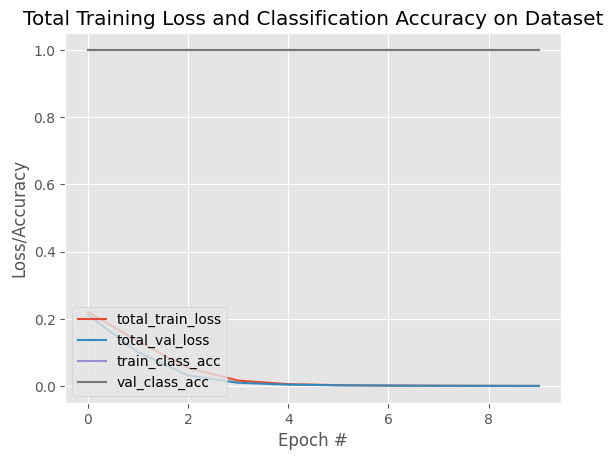

In [20]:
# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(objectDetector, MODEL_PATH)
# serialize the label encoder to disk
print("[INFO] saving label encoder...")

try:
	f = open(LE_PATH, "wb")
except:
	# if the file doesn't exist, create the file using OS
	if not os.path.exists(LE_PATH):
		os.makedirs(os.path.dirname(LE_PATH))
	f = open(LE_PATH, "wb")

f.write(pickle.dumps(le))
f.close()
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_class_acc"], label="train_class_acc")
plt.plot(H["val_class_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# save the training plot
plotPath = os.path.sep.join([PLOTS_PATH, "training.png"])
try:
	plt.savefig(plotPath)
except:
	# if the file doesn't exist, create the file using OS
    if not os.path.exists(plotPath):
        os.makedirs(os.path.dirname(plotPath))
    plt.savefig(plotPath)

In [21]:
# USAGE
# python predict.py --input dataset/images/face/image_0131.jpg
# import the necessary packages
from torchvision import transforms
import mimetypes
import argparse
import imutils
import pickle
import torch
import cv2
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to input image/text file of image paths")
# args = vars(ap.parse_args())

In [22]:
# determine the input file type, but assume that we're working with
# single input image
# filetype = mimetypes.guess_type(args["input"])[0]
# imagePaths = [args["input"]]
# # if the file type is a text file, then we need to process *multiple*
# # images
# if "text/plain" == filetype:
# 	# load the image paths in our testing file
# 	imagePaths = open(args["input"]).read().strip().split("\n")

In [23]:
# load our object detector, set it evaluation mode, and label
# encoder from disk
print("[INFO] loading object detector...")
model = torch.load(MODEL_PATH).to(DEVICE)
model.eval()
le = pickle.loads(open(LE_PATH, "rb").read())
# define normalization transforms
transforms = transforms.Compose([
	transforms.ToPILImage(),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

[INFO] loading object detector...


In [24]:
# read txt file
with open(TEST_PATHS, 'r') as f:
    image_file_paths_list_test = f.readlines()

imagePaths = [path.strip() for path in image_file_paths_list_test]

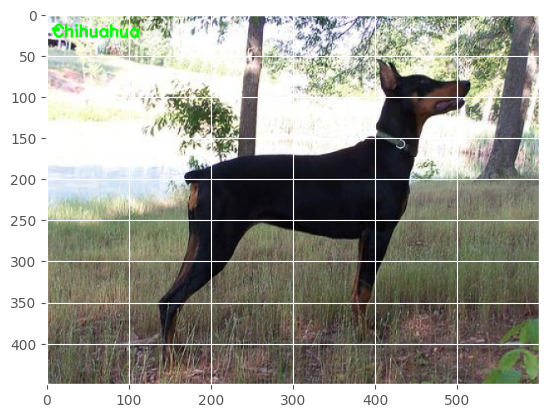

In [25]:
# loop over the images that we'll be testing using our bounding box
# regression model
cnt = 0
for imagePath in imagePaths:
	# load the image, copy it, swap its colors channels, resize it, and
	# bring its channel dimension forward
	image = cv2.imread(imagePath)
	orig = image.copy()
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	image = image.transpose((2, 0, 1))
	# convert image to PyTorch tensor, normalize it, flash it to the
	# current device, and add a batch dimension
	image = torch.from_numpy(image)
	image = transforms(image).to(DEVICE)
	image = image.unsqueeze(0)
	
    	# predict the bounding box of the object along with the class
	# label
	(boxPreds, labelPreds) = model(image)
	(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
	labelPreds = torch.nn.Softmax(dim=-1)(labelPreds)
	i = labelPreds.argmax(dim=-1).cpu()
	label = le.inverse_transform(i)[0]
	
    	# resize the original image such that it fits on our screen, and
	# grab its dimensions
	orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
	orig = imutils.resize(orig, width=600)
	(h, w) = orig.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)
	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(orig, classes[label], (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (0, 255, 0), 2)
	cv2.rectangle(orig, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	# show the output image 
	# cv2.imshow("Output", orig)
	plt.imshow(orig)
	plt.savefig(f"output_{cnt}.jpg")
	# cv2.waitKey(0)
	cnt+=1
	if cnt==2:
		break